In [1]:
import os
import yaml
import logging
import numpy as np
import importlib
import subprocess
import scipy.stats as stats
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Any, Optional, Tuple, Dict
from datetime import datetime
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr, kurtosis, skew

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# расширяем поле ноутбука для удобства
from IPython.display import display, HTML
display(HTML('<style>.container {width:87% !important;}</style>'))
display(HTML("<style>.output_scroll {height:auto !important; max-height:10000px !important;}</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# Настройки для pandas (количество отображаемых колонок)
pd.set_option('display.max_columns', 100)

In [5]:
# Определение стиля для pyplot
plt.style.use('ggplot')

In [6]:
# Текущая рабочая директория
cwd = Path().resolve()

# Поднимаемся на один уровень выше
project_root = cwd.parent

# Добавляем корень проекта в sys.path
sys.path.append(str(project_root))

# Загрузка данных из config.yaml
from src.utils import ml_utils, eda_utils

# Путь к файлу config.yaml
config_path = project_root / "config" / "config.yaml"

# Загружаем конфиг
config = ml_utils.load_config(config_path)

## 3.1. Загрузка данных

In [7]:
# Загрузка train и test
df_train = ml_utils.data_load(data_type='train', config=config)
df_test = ml_utils.data_load(data_type='test', config=config)

In [8]:
# Вывод первых 5 строк тренировочного датасета
df_train.head()

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,230,376.0,0.0,0.0,214.6,0.0,1003.5,762.4,3,16.28
1,231,491.0,26.0,123.0,210.0,3.9,882.0,699.0,56,59.59
2,232,250.0,0.0,95.7,187.4,5.5,956.9,861.2,3,13.82
3,233,310.0,0.0,0.0,192.0,0.0,1012.0,830.0,90,35.76
4,234,252.1,97.1,75.6,193.8,8.3,835.5,821.4,28,33.40


In [9]:
# Вывод первых 5 строк тестового датасета
df_test.head()

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,0,167.4,129.9,128.6,175.5,7.8,1006.3,746.6,28
1,1,475.0,118.8,0.0,181.1,8.9,852.1,781.5,7
2,2,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,100
3,3,307.0,0.0,0.0,193.0,0.0,968.0,812.0,365
4,4,143.6,0.0,174.9,158.4,17.9,942.7,844.5,28


In [10]:
# Удаление неинформативного признака Id
df_train = df_train.drop(columns=["Id"])
df_test = df_test.drop(columns=["Id"])

In [11]:
# Удаление дубликатов
df_train_cleaned = df_train.drop_duplicates()
test_cleaned = df_test.drop_duplicates()

## 3.2. Создание инженерных признаков

In [12]:
# Создание признаков (w_c, SP_pct)
df_train_feat = eda_utils.add_concrete_ratios(df_train_cleaned)
df_test_feat = eda_utils.add_concrete_ratios(df_test)

df_train_feat.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength,W/C,Sp/C_pct
0,376.0,0.0,0.0,214.6,0.0,1003.5,762.4,3,16.28,0.570745,0.000000
1,491.0,26.0,123.0,210.0,3.9,882.0,699.0,56,59.59,0.427699,0.007943
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,3,13.82,0.749600,0.022000
3,310.0,0.0,0.0,192.0,0.0,1012.0,830.0,90,35.76,0.619355,0.000000
4,252.1,97.1,75.6,193.8,8.3,835.5,821.4,28,33.40,0.768743,0.032923


## 3.3. Оценка объема данных и выбор алгоритмов

In [13]:
# Формируем список алгоритмов исходя из объема данных по правилу NEPV
models = ml_utils.check_models_by_nepv(df_train_feat, config)

[REGRESSION] Правило NEPV: 781 наблюдений / 11 признаков = 71.00
LinearRegression / Ridge / Lasso — соответствуют (≥ 20)
CHAID (не реализован в sklearn) — соответствует (≥ 50)
Сложные модели (RF, Boosting и др.) — не соответствуют (< 200)
DecisionTreeRegressor (CART) — добавлен с осторожностью. NEPV к нему не применяется строго.

Список рекомендованных моделей: ['LinearRegression', 'Ridge', 'Lasso', 'DecisionTreeRegressor']


## 3.4. Проверка порядка признаков в тренировочном и тестовом датасете

In [14]:
# Создание массива из признаков и массива из целевой переменной
X = df_train_feat.drop(columns=["Strength"])
y = df_train_feat["Strength"]

In [15]:
# Сравниваем порядок признаков в тренировочном и тестовом датасете
if list(X.columns) == list(df_test_feat.columns):
    print("Порядок признаков совпадает")
else:
    print("Порядок признаков отличается")

Порядок признаков совпадает


## 3.5. Генерация EDA отчета

#### Предварительный отчет

In [ ]:
# Общая информация
df_train_feat.info()

In [ ]:
# Проверка на пропуски train
df_train_feat.isna().sum()

In [ ]:
# Проверка на пропуски test
df_train_feat.isna().sum()

In [ ]:
# Основные статистики train
df_train_feat.describe()

#### Генерация подробного отчета ydataprofaling

In [ ]:
# Генерация отчета по тренировочным данным с помощью ydata-profiling
ml_utils.eda_report(df_train_feat, "train", config)

## 3.6. Анализ выбросов

#### Анализ выбросов

In [ ]:
# Построение сводной таблицы по выбросам на оснвове IQR и значений ГОСТ
summary_df,  outlier_masks_df = eda_utils.detect_outliers(df_train_feat, config)
summary_df

In [ ]:
# Построение графиков 
ml_utils.plot_outliers(df_train_feat, summary_df, max_plots=10)

In [ ]:
# Сохранение отчетов
output_dir=Path().resolve().parent / config["output"]["eda_report_dir"]

ml_utils.save_outliers_report(summary_df, output_dir=output_dir)

## 3.7. Анализ нулей в признаках

#### Анализ признаков с нулнвыми значениями

In [ ]:
config = eda_utils.analyze_zeros(df_train_feat, config)

## 3.8. Анализ зависимости целевой переменнной от признаков

### Анализ корреляции целевой переменнной и признаков

In [16]:
# Создает комплексный датафрейм c результатами анализа
# корреляции признаков и целевой переменной
df_corr_target = ml_utils.create_feature_analysis(X, y)
df_corr_target

,feature,pearson_corr,spearman_corr,spearman_p_value,skewness,kurtosis
0,Age,0.340194,0.605166,0.0000,3.194974,11.474745
1,Cement,0.487081,0.457532,0.0000,0.551298,-0.476898
2,Superplasticizer,0.337472,0.319406,0.0000,1.018888,1.828718
3,Sp/C_pct,0.110190,0.155413,0.0000,0.861070,0.778522
4,Blast Furnace Slag,0.097618,0.143321,0.0001,0.896768,-0.372511
5,Fly Ash,-0.081246,-0.056658,0.1136,0.547411,-1.302600
6,Coarse Aggregate,-0.144448,-0.160593,0.0000,-0.086176,-0.590294
7,Fine Aggregate,-0.195630,-0.201790,0.0000,-0.292143,-0.205708
8,Water,-0.260922,-0.278070,0.0000,0.030519,0.110556
9,W/C,-0.480962,-0.498596,0.0000,0.948181,0.635697


**Выводы:** Признак Fly Ash показывает очень слабую и статистически незначимую связь с целевой переменной Strength. Поэтому его стоит объединить с другими признаками или удалить

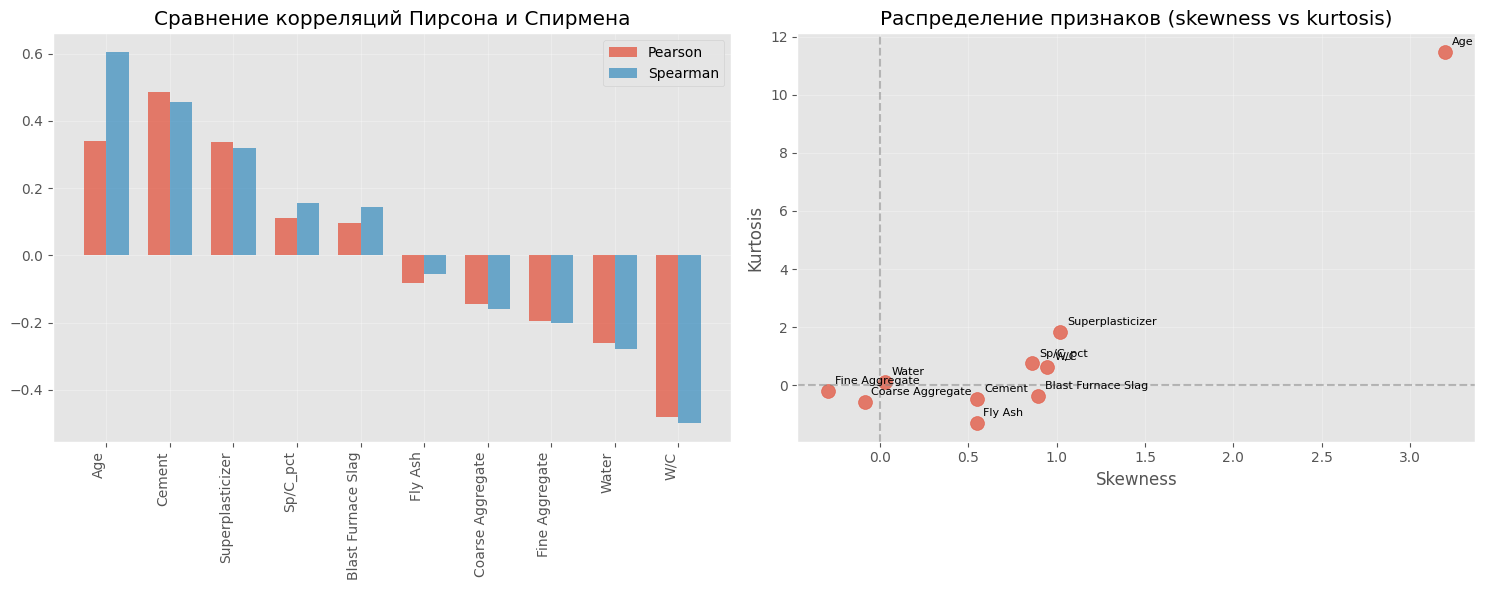

In [18]:
# Визуализация анализа признаков
ml_utils.visualize_feature_analysis(df_corr_target) 

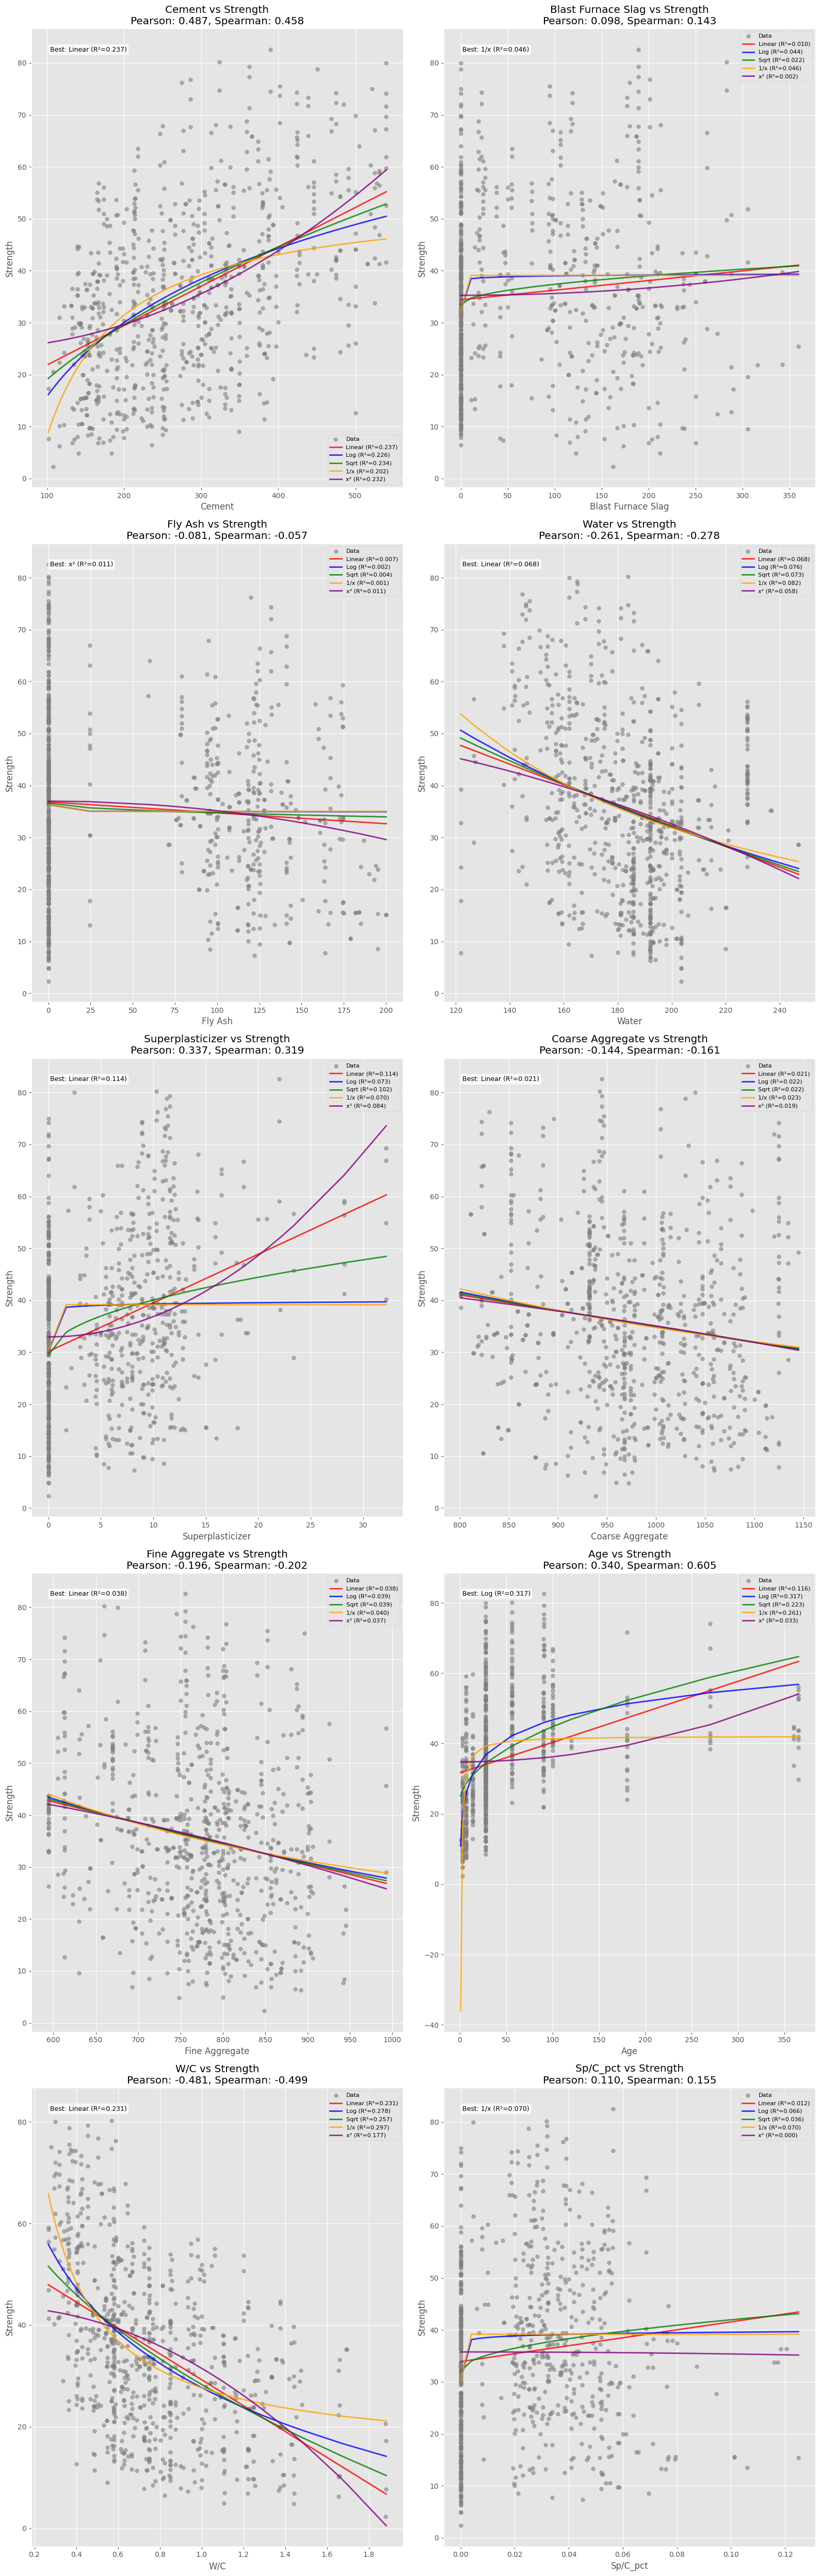

In [17]:
# Визуализируем тренды зависимостей таргета от признаков
df_trend_results = ml_utils.plot_feature_trends(df_train_feat,
                                                config, 
                                                target='Strength',
                                                figsize=(16, 50),
                                                alpha=0.25)

In [19]:
# Выводим датасет преобразований призгнаков и значений R2
df_trend_results

,feature,best_transformation,best_r2_score,linear_r2_score,log_r2_score,sqrt_r2_score,reciprocal_r2_score,square_r2_score
0,Cement,Linear,0.237248,0.237248,0.226309,0.233803,0.201690,0.232405
1,Blast Furnace Slag,1/x,0.045861,0.009529,0.043971,0.021669,0.045861,0.001872
2,Fly Ash,x²,0.011304,0.006601,0.001599,0.003937,0.001437,0.011304
3,Water,Linear,0.068080,0.068080,0.076396,0.072503,0.082124,0.058149
4,Superplasticizer,Linear,0.113888,0.113888,0.072762,0.101963,0.069828,0.083929
5,Coarse Aggregate,Linear,0.020865,0.020865,0.022249,0.021573,0.023494,0.019373
6,Fine Aggregate,Linear,0.038271,0.038271,0.039232,0.038813,0.039691,0.036842
7,Age,Log,0.316769,0.115732,0.316769,0.222957,0.260855,0.033408
8,W/C,Linear,0.231324,0.231324,0.278245,0.257072,0.297398,0.177113
9,Sp/C_pct,1/x,0.069828,0.012142,0.066454,0.036067,0.069828,0.000018


In [23]:
# Добавляем новые значения в существующий config
new_transformations = dict(zip(df_trend_results['feature'],
                               df_trend_results['best_transformation']))

config['best_transformations'].update(new_transformations)

### Анализ мультиколлинеарности признаков